In [5]:
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense,BatchNormalization
from tensorflow.keras import applications
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras import optimizers
import tensorflow
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [8]:
# dimensions of our images.
img_width, img_height = 150, 150

directory = r'C:\Users\Alankrit\Videos\PetImages'

#To Save the Weights to be Used Later in Predictions
top_model_weights_path = os.path.join(directory,'bottleneck_fc_model.h5')
train_data_dir = os.path.join(directory,'data\\train')
validation_data_dir = os.path.join(directory,'data\\validation')



#SET TO THE NUMBER OF IMAGES IN TRAIN AND VALIDATION DIRECTORIES
nb_train_samples = 15099
nb_validation_samples = 8000
epochs = 50
batch_size = 32

#FUNCTION TO PREDICT THE CONV. BLOCKS OUTPUT FROM VGG16 TO BE USED IN TRAINING TOP MODEL 
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    
    
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False) #SETTING SHUFFLE=FALSE to be manually able to label the CONV BLOCKS Outputs used in TOP MODEL TRAINING
    
    bottleneck_features_train = model.predict_generator(
        generator)
    
    
    print("SAVING TRAINING FEATURE OUTPUTS FROM CONVOLUTIONAL BLOCKS")
    np.save(open(os.path.join(directory,'conv_features_train.npy'), 'wb'),
            bottleneck_features_train)

    
    
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    bottleneck_features_validation = model.predict_generator(
        generator)
    
    print("\nSAVING VALIDATION FEATURE OUTPUTS FROM CONVOLUTIONAL BLOCKS\n")
    np.save(open(os.path.join(directory,'conv_features_validation.npy'), 'wb'),
            bottleneck_features_validation)

    
  

In [9]:
  
    
print("CALLING FUNCTION TO PRODUCE OUTPUTS USING CONVOLUTIONAL BLOCKS OF VGG16")
save_bottlebeck_features()

train_data = np.load(open(os.path.join(directory,'conv_features_train.npy'),'rb'))
print(train_data.shape)

CALLING FUNCTION TO PRODUCE OUTPUTS USING CONVOLUTIONAL BLOCKS OF VGG16
Found 21000 images belonging to 2 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
SAVING TRAINING FEATURE OUTPUTS FROM CONVOLUTIONAL BLOCKS
Found 4000 images belonging to 2 classes.

SAVING VALIDATION FEATURE OUTPUTS FROM CONVOLUTIONAL BLOCKS

(21000, 4, 4, 512)


In [10]:
validation_data = np.load(open(os.path.join(directory,'conv_features_validation.npy'),'rb'))
print(validation_data.shape)

(4000, 4, 4, 512)


# FUNCTION TO TRAIN TOP MODEL

In [16]:
print("LOADING PREDICTED FEATURE OUTPUTS FROM CONV BLOCKS OF VGG16\n")
from tensorflow.keras import regularizers
#SETTING HIGH REGULARIZATION SINCE VGG16 BLOCKS ARE HIGHLY COMPLEX AND DATASET IS COMPARATIVELY SMALL
reg_l2=l2(0.35)
reg_l1_l2=regularizers.l1_l2(l1=0.01, l2=0.2)


if train_data.shape[0]%2!=0:
    print("ODD NUMBER OF SAMPLE OUTPUTS FROM CONV FOR TRAINING DATA:(\n NEED TO ACCORDINGLY CUT ONE FEATURE OUTPUT\n\n")    
    train_data= train_data[1:]

train_labels = np.array(
    [0] * (train_data.shape[0]//2) + [1] * (train_data.shape[0]//2))


if validation_data.shape[0]%2!=0:
    print("ODD NUMBER OF SAMPLE OUTPUTS FROM CONV for VALIDATION DATA :(\n NEED TO ACCORDINGLY CUT ONE FEATURE OUTPUT\n\n")    
    validation_data= validation_data[1:]

validation_labels = np.array(
    [0] * (validation_data.shape[0]//2)  + [1] * (validation_data.shape[0]//2))


#CREATING TOP MODEL ARCHITECTURE
print("CREATING CUSTOM TOP LAYER ARCHITECTURE\n")
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(128, activation='relu',kernel_regularizer=reg_l2))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())


ini_lr = 0.001
adam= optimizers.Adam(learning_rate=ini_lr)
sgd = optimizers.SGD(learning_rate=ini_lr,momentum=0.9)
adagrad = optimizers.Adagrad(learning_rate=ini_lr)
#CALLBACKS

#LEARNING RATE SCHEDULER - TO DECREASE LEARNING RATE AFTER CERTAIN EPOCHS FOR SLOW & OPTIMUM GRADIENT DESCENT TOWARDS THE END
def scheduler(epoch, lr):
     if epoch%5==0: #REDUCING AFTER EVERY EPOCH WITH MULTIPLE OF 20 [ZEROTH EPOCH(INCLUSIVE)]
        return lr * 0.5
     else:
        return lr

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
callback_scheduler =LearningRateScheduler(scheduler)

#COMPILING MODEL
model.compile(optimizer=sgd,
              loss='binary_crossentropy', metrics=['accuracy'])


print("\n\n\n\nFITTING MODEL TO TRAIN TOP MODEL ON OUTPUT FEATURES OF CONV BLOCKS OF VGG16\n")
history = model.fit(train_data, train_labels,
          epochs=35,
          batch_size=batch_size,
          callbacks=[callback_scheduler,earlyStopping],
          validation_data=(validation_data, validation_labels))

#saving weights for trained custom top layer

print("\nSAVING WEIGHTS FOR THE TOP MODEL TO BE USED IN PREDICTIONS LATER")
model.save_weights(top_model_weights_path)

LOADING PREDICTED FEATURE OUTPUTS FROM CONV BLOCKS OF VGG16

CREATING CUSTOM TOP LAYER ARCHITECTURE

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               1048704   
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 1,049,345
Trainable params: 1,049,089
Non-trainable params: 256
_________________________________________________________________
None




EVALUATING MODEL TRAINING PERFORMANCE ON TRAINING AND VALIDATION DATASETS


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


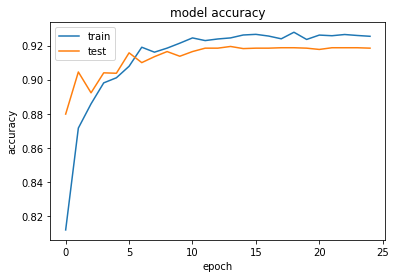

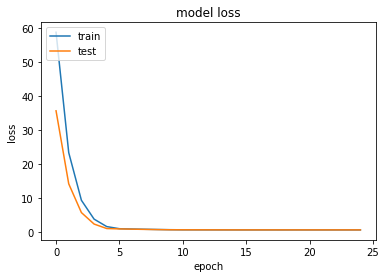

In [17]:
print("EVALUATING MODEL TRAINING PERFORMANCE ON TRAINING AND VALIDATION DATASETS\n\n")
print(history.
      history.keys())


#summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()